In [1]:
import silence_tensorflow.auto
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers, active_enhancers_vs_active_promoters
from epigenomic_dataset.utils import normalize_epigenomic_data
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from cache_decorator import Cache
from tqdm.keras import TqdmCallback
from barplots import barplots
from keras_mixed_sequence import MixedSequence, VectorSequence
from keras_bed_sequence import BedSequence
from ucsc_genomes_downloader import Genome

## Data retrieval
First, we retrieve the data and impute and scale them.

In [2]:
cell_line = "K562"
window_size = 256
task = "active_enhancers_vs_active_promoters"

X, y = active_enhancers_vs_active_promoters(
    cell_line=cell_line,
    window_size=window_size
)

genome = Genome("hg38")

bed_X = X.reset_index()
bed = bed_X[bed_X.columns[:5]]

Loading chromosomes for genome hg38:   0%|          | 0/25 [00:00<?, ?it/s]

In [3]:
X

chrom                             SMAD5  NCOA2  ZNF23  NR2F6  CEBPZ  SNIP1  \
chrom chromStart chromEnd strand                                             
chr1  633305     633561   +        0.21   0.53   0.44   0.63   0.28   0.10   
      960397     960653   +        2.44   0.38   1.14   0.92   1.08   1.44   
      1013249    1013505  +        1.94   0.67   0.68   0.78   0.94   0.85   
      1019872    1020128  +        2.09   0.00   0.01   0.11   0.19   0.00   
      1232032    1232288  +        2.13   0.25   0.53   0.75   0.97   0.29   
...                                 ...    ...    ...    ...    ...    ...   
chrX  88096209   88096465 .        0.33   0.18   0.34   0.49   1.17   0.67   
      88096661   88096917 .        0.66   0.29   0.21   0.46   0.28   0.51   
      8981819    8982075  .        0.75   0.40   0.27   0.97   0.05   0.24   
      9352715    9352971  .        1.81   1.20   0.56   0.70   0.88   0.98   
      9818640    9818896  .        0.22   0.31   0.21   0.36   0.79   0.44   

chrom                             ZBTB7A  ZNF133   NRF1   TAF1  ...  SIN3A  \
chrom chromStart chromEnd strand                                ...          
chr1  633305     633561   +         0.00    0.74   0.51   0.00  ...   0.39   
      960397     960653   +        18.06    1.58   1.94   7.08  ...   4.88   
      1013249    1013505  +         2.69    0.93  26.46   6.05  ...   9.57   
      1019872    1020128  +        14.37    0.13   1.84   5.07  ...   2.31   
      1232032    1232288  +         2.89    1.02  57.57  12.15  ...   4.40   
...                                  ...     ...    ...    ...  ...    ...   
chrX  88096209   88096465 .         0.00    0.35   0.32   0.00  ...   0.10   
      88096661   88096917 .         0.31    0.41   0.52   0.00  ...   0.26   
      8981819    8982075  .         0.67    0.37   0.54   0.00  ...   0.47   
      9352715    9352971  .         5.63    0.78   1.06  14.50  ...   1.55   
      9818640    9818896  .         0.13    0.16   0.67   0.00  ...   0.37   

chrom                             SMARCC2  ZFP91   E2F4  NR3C1  SAFB2  E4F1  \
chrom chromStart chromEnd strand                                              
chr1  633305     633561   +          0.87   0.30   0.00   1.29   0.25  0.68   
      960397     960653   +          1.36   1.77  20.14   1.75   1.23  4.15   
      1013249    1013505  +          2.18   0.78   3.61   1.13   0.92  2.99   
      1019872    1020128  +          0.13   0.03   4.01   0.01   0.00  0.15   
      1232032    1232288  +          0.98   0.74  43.74   0.19   0.53  7.95   
...                                   ...    ...    ...    ...    ...   ...   
chrX  88096209   88096465 .          0.00   0.38   0.00   0.57   0.08  0.16   
      88096661   88096917 .          0.47   0.10   0.00   0.26   1.34  0.25   
      8981819    8982075  .          0.00   0.50   0.00   0.28   0.00  0.54   
      9352715    9352971  .          2.86   1.26   5.38   0.38   1.18  4.00   
      9818640    9818896  .          0.37   0.29   0.00   0.00   0.09  0.80   

chrom                             NCOR1  NCOA1  KLF1  
chrom chromStart chromEnd strand                      
chr1  633305     633561   +        0.07   0.96  0.66  
      960397     960653   +        2.93   1.45  2.53  
      1013249    1013505  +        2.23   0.92  1.48  
      1019872    1020128  +        0.00   0.02  0.01  
      1232032    1232288  +        0.51   0.33  2.00  
...                                 ...    ...   ...  
chrX  88096209   88096465 .        0.65   0.20  0.88  
      88096661   88096917 .        0.16   0.43  0.36  
      8981819    8982075  .        0.33   0.14  0.05  
      9352715    9352971  .        3.45   0.84  2.35  
      9818640    9818896  .        0.50   0.65  0.04  

[18048 rows x 429 columns]

In [4]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, ReLU, Concatenate, Layer
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalAveragePooling1D, GlobalMaxPool1D, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from extra_keras_metrics import get_complete_binary_metrics

In [5]:
def build_ffnn(X:pd.DataFrame):
    input_epigenomic_data = Input(shape=(X.shape[1]), name="epigenomic_data")
    hidden = Dense(64, activation="relu")(input_epigenomic_data)
    #hidden = BatchNormalization()(hidden)
    #hidden = ReLU()(hidden)

    for _ in range(2):
        hidden = Dense(
            32,
            activation="relu",
            #kernel_regularizer=regularizers.l1_l2(),
            #activity_regularizer=regularizers.l1_l2(),
        )(hidden)
        #hidden = Dropout(rate=0.3)(hidden)

    last_hidden_ffnn = hidden

    output_ffnn = Dense(1, activation="sigmoid")(last_hidden_ffnn)

    ffnn = Model(
        inputs=input_epigenomic_data,
        outputs=output_ffnn,
        name="FFNN"
    )

    ffnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )
    return ffnn, input_epigenomic_data, last_hidden_ffnn

In [6]:
def build_cnn(window_size: int):
    input_sequence_data = Input(shape=(window_size, 4), name="sequence_data")
    hidden = Conv1D(64, kernel_size=6, activation="linear")(input_sequence_data)
    # hidden = BatchNormalization()(hidden)
    hidden = ReLU()(hidden)

    for _ in range(2):
        hidden = Conv1D(
            32,
            kernel_size=4,
            activation="relu",
            #kernel_regularizer=regularizers.l1_l2(),
            #activity_regularizer=regularizers.l1_l2(),
        )(hidden)
        #hidden = Dropout(rate=0.3)(hidden)
        #hidden = MaxPool1D(pool_size=2)(hidden)

    # hidden = Flatten()(hidden)
    # hidden = GlobalMaxPool1D()(hidden)
    hidden = GlobalAveragePooling1D()(hidden)
    last_hidden_cnn = Dense(64, activation="relu")(hidden)
    output_cnn = Dense(1, activation="sigmoid")(last_hidden_cnn)

    cnn = Model(
        inputs=input_sequence_data,
        outputs=output_cnn,
        name="CNN"
    )

    cnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )
    
    return cnn, input_sequence_data, last_hidden_cnn

In [7]:
def build_mmnn(
    X:pd.DataFrame=None,
    window_size:int=None,
    input_sequence_data:Layer=None,
    input_epigenomic_data:Layer=None,
    last_hidden_cnn:Layer=None,
    last_hidden_ffnn:Layer=None
):
    if X is not None:
        _, input_epigenomic_data, last_hidden_ffnn = build_ffnn(X)
    if window_size is not None:
        _, input_sequence_data, last_hidden_cnn = build_cnn(window_size)
        
    concatenation_layer = Concatenate()([
        last_hidden_ffnn,
        last_hidden_cnn
    ])

    last_hidden_mmnn = Dense(64, activation="relu")(concatenation_layer)
    output_mmnn = Dense(1, activation="sigmoid")(last_hidden_mmnn)

    mmnn = Model(
        inputs=[input_epigenomic_data, input_sequence_data],
        outputs=output_mmnn,
        name="SiameseMMNN" if X is None else "MMNN"
    )

    mmnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )

    return mmnn

In [8]:
def get_cnn_sequence(
    genome:Genome,
    bed:pd.DataFrame,
    y:np.ndarray,
    batch_size=1024
) -> MixedSequence:
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

def get_ffnn_sequence(
    X:np.ndarray,
    y:np.ndarray,
    batch_size=1024
) -> MixedSequence:
    return MixedSequence(
        x={
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

def get_mmnn_sequence(
    genome:Genome,
    bed:pd.DataFrame,
    X:np.ndarray,
    y:np.ndarray,
    batch_size=1024
) -> MixedSequence:
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            ),
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

@Cache(
    cache_path=[
        "{task}/{model_name}/history_{_hash}.csv.xz",
        "{task}/{model_name}/performance_{_hash}.csv.xz",
    ],
    args_to_ignore=[
        "model", "training_sequence", "test_sequence"
    ]
)
def train_model(
    model:Model,
    model_name: str,
    task: str,
    training_sequence:MixedSequence,
    test_sequence:MixedSequence,
    holdout_number: int
):
    history = pd.DataFrame(model.fit(
        train_sequence,
        validation_data=test_sequence,
        epochs=1000,
        verbose=False,
        callbacks=[
            EarlyStopping("loss"),
            # I have commented this because we do not need this loading bar
            # when running the main experiment loop. When you experiment with
            # the model structure you may want to enable this to get a feel
            # of how the model is performing during the training.
            TqdmCallback(verbose=1)
        ]
    ).history)
    
    train_evaluation = dict(zip(model.metrics_names, model.evaluate(train_sequence, verbose=False)))
    test_evaluation = dict(zip(model.metrics_names, model.evaluate(test_sequence, verbose=False)))
    train_evaluation["run_type"] = "train"
    test_evaluation["run_type"] = "test"
    for evaluation in (train_evaluation, test_evaluation):
        evaluation["model_name"] = model_name
        evaluation["holdout_number"] = holdout_number
    
    evaluations = pd.DataFrame([
        train_evaluation,
        test_evaluation
    ])
    
    return history, evaluations

## Model evaluation
In order to evaluate the model, we create a generator of **stratified** holdouts.

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

number_of_splits = 2

holdouts_generator = StratifiedShuffleSplit(
    n_splits=number_of_splits,
    test_size=0.2
)

### Evaluation of the models predictions
In order to evaluate the models predictions, we consider the Accuracy, AUPRC and AUROC metrics:

In [11]:
# Create a list to store all the computed performance
all_performance = []

# Start the main loop, iterating through the holdouts
for holdout_number, (train_indices, test_indices) in tqdm(
    enumerate(holdouts_generator.split(X, y)),
    total=number_of_splits,
    desc="Computing holdouts"
):
    train_bed, test_bed = bed.iloc[train_indices], bed.iloc[test_indices]
    train_X, test_X = X.iloc[train_indices], X.iloc[test_indices]
    train_X, test_X = normalize_epigenomic_data()
    train_y, test_y = y.iloc[train_indices], y.iloc[test_indices]
    
    train_X, test_X = train_X.values, test_X.values
    train_y = train_y.values.flatten()
    test_y = test_y.values.flatten()
    
    ffnn, input_epigenomic_data, last_hidden_ffnn = build_ffnn(train_X)
    cnn, input_sequence_data, last_hidden_cnn = build_cnn(window_size)
    mmnn1 = build_mmnn(train_X, window_size)
    mmnn2 = build_mmnn(
        input_sequence_data=input_sequence_data,
        input_epigenomic_data=input_epigenomic_data,
        last_hidden_ffnn=last_hidden_ffnn,
        last_hidden_cnn=last_hidden_cnn
    )
    for model, train_sequence, test_sequence in tqdm(
        (
            (ffnn, get_ffnn_sequence(train_X, train_y), get_ffnn_sequence(test_X, test_y)),
            (cnn, get_cnn_sequence(genome, train_bed, train_y), get_cnn_sequence(genome, test_bed, test_y)),
            (mmnn1, get_mmnn_sequence(genome, train_bed, train_X, train_y), get_mmnn_sequence(genome, test_bed, test_X, test_y)),
            (mmnn2, get_mmnn_sequence(genome, train_bed, train_X, train_y), get_mmnn_sequence(genome, test_bed, test_X, test_y)),
        ),
        desc="Training models",
        leave=False
    ):
        # We compute the model performance
        history, performance = train_model(
            model,
            model.name,
            task,
            train_sequence,
            test_sequence,
            holdout_number
        )
        # We chain the computed performance to the performance list
        all_performance.append(performance)
        
# We convert the computed performance list into a DataFrame
all_performance = pd.concat(all_performance)

Computing holdouts:   0%|          | 0/2 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [12]:
all_performance

,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,threat_score,fowlkes_mallows_index,informedness,markedness,LR_pos,LR_neg,DOR,run_type,model_name,holdout_number
0,0.619148,0.693933,1.000000,0.693933,0.500000,0.693933,0.819316,0.500000,0.000000,0.000000,...,0.693933,0.500000,0.833026,-0.306067,1.000000,0.000000,1.000000,train,FFNN,0
1,0.616748,0.693906,1.000000,0.693906,0.500000,0.693906,0.819297,0.500000,0.000000,0.000000,...,0.693906,0.500000,0.833010,-0.306094,1.000000,0.000000,1.000000,test,FFNN,0
0,0.399518,0.839798,0.907675,0.867582,0.883798,0.931993,0.887176,0.796789,0.685902,0.092325,...,0.797230,0.796789,0.887403,0.633760,2.889781,0.134603,3.920983,train,CNN,0
1,0.415406,0.834903,0.902994,0.865010,0.874732,0.923492,0.883594,0.791769,0.680543,0.097006,...,0.791463,0.791769,0.883798,0.620788,2.826652,0.142542,3.802347,test,CNN,0
0,0.408891,0.831209,0.951492,0.830111,0.879136,0.931120,0.886667,0.754995,0.558497,0.048508,...,0.796408,0.754995,0.888732,0.665589,2.155122,0.086854,3.081545,train,MMNN,0
1,0.423142,0.833795,0.950100,0.833625,0.870007,0.923457,0.888060,0.760118,0.570136,0.049900,...,0.798658,0.760118,0.889959,0.668062,2.210232,0.087523,3.168712,test,MMNN,0
0,0.361208,0.859122,0.891606,0.904058,0.900944,0.939301,0.897789,0.838539,0.785472,0.108394,...,0.814534,0.838539,0.897811,0.665744,4.156123,0.137999,5.193440,train,SiameseMMNN,0
1,0.378202,0.848753,0.883433,0.897041,0.891778,0.931291,0.890185,0.826784,0.770136,0.116567,...,0.802102,0.826784,0.890211,0.641573,3.843280,0.151359,4.773152,test,SiameseMMNN,0
0,0.618676,0.693933,1.000000,0.693933,0.500000,0.693933,0.819316,0.500000,0.000000,0.000000,...,0.693933,0.500000,0.833026,-0.306067,1.000000,0.000000,1.000000,train,FFNN,1
1,0.615489,0.693906,1.000000,0.693906,0.500000,0.693906,0.819297,0.500000,0.000000,0.000000,...,0.693906,0.500000,0.833010,-0.306094,1.000000,0.000000,1.000000,test,FFNN,1


### Results visualization
Now that we have run our experiment we can visualize its performance:

Rendering barplots:   0%|          | 0/28 [00:00<?, ?it/s]

((<Figure size 1600x660 with 1 Axes>,
  <Figure size 1600x660 with 1 Axes>,
  <Figure size 1600x660 with 1 Axes>,
  <Figure size 1600x660 with 1 Axes>,
  <Figure size 1600x660 with 1 Axes>,
  <Figure size 1600x660 with 1 Axes>,
  <Figure size 1600x660 with 1 Axes>,
  <Figure size 1600x660 with 1 Axes>,
  <Figure size 1600x660 with 1 Axes>,
  <Figure size 1600x660 with 1 Axes>,
  <Figure size 1600x660 with 1 Axes>,
  <Figure size 1600x660 with 1 Axes>,
  <Figure size 1600x660 with 1 Axes>,
  <Figure size 1600x660 with 1 Axes>,
  <Figure size 1600x660 with 1 Axes>,
  <Figure size 1600x660 with 1 Axes>,
  <Figure size 1600x660 with 1 Axes>,
  <Figure size 1600x660 with 1 Axes>,
  <Figure size 1600x660 with 1 Axes>,
  <Figure size 1600x660 with 1 Axes>,
  <Figure size 1600x660 with 1 Axes>,
  <Figure size 1600x660 with 1 Axes>,
  <Figure size 1600x660 with 1 Axes>,
  <Figure size 1600x660 with 1 Axes>,
  <Figure size 1600x660 with 1 Axes>,
  <Figure size 1600x660 with 1 Axes>,
  <Figure si

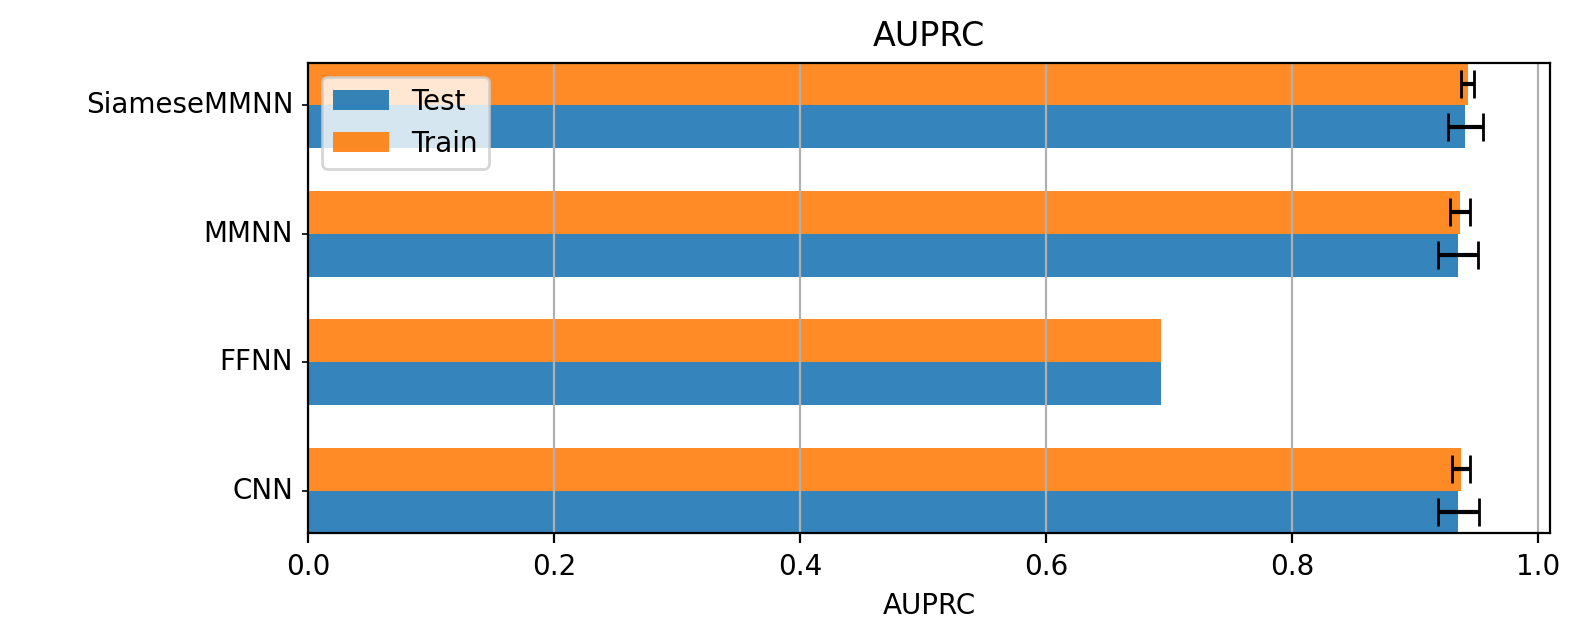

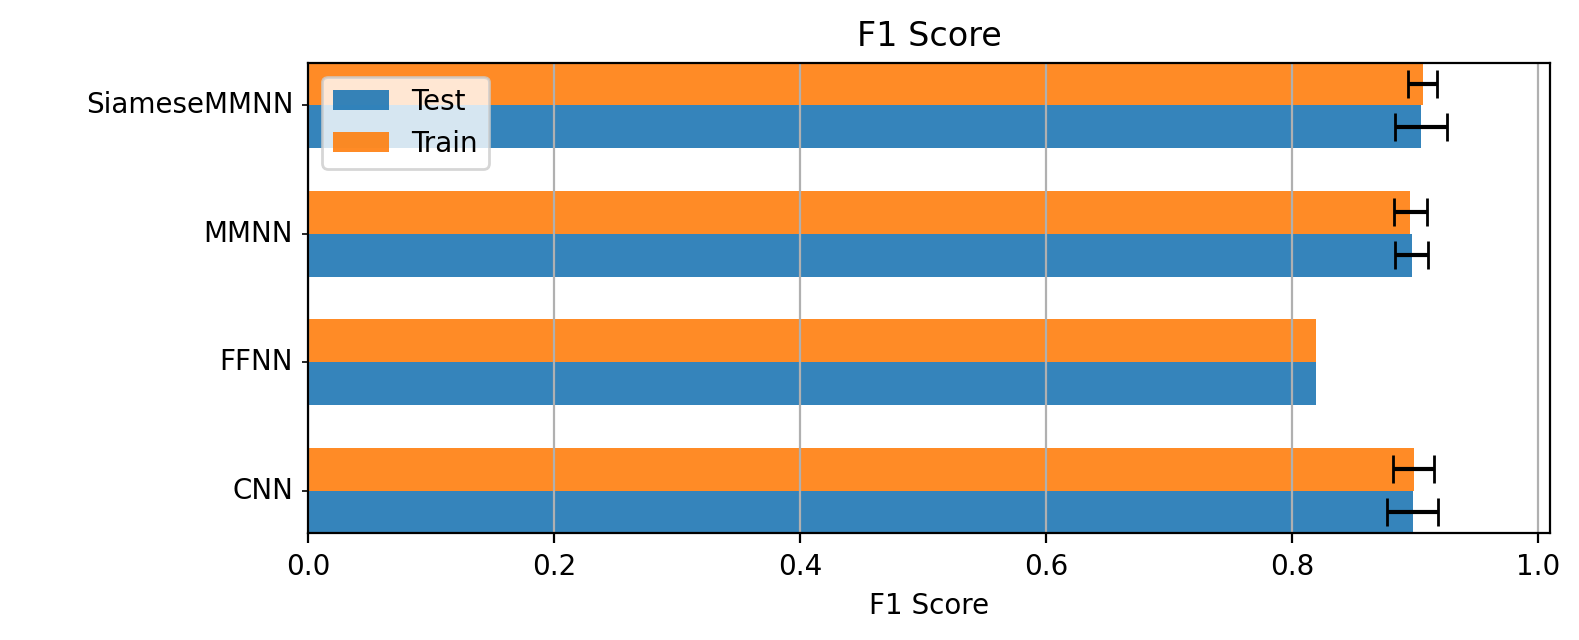

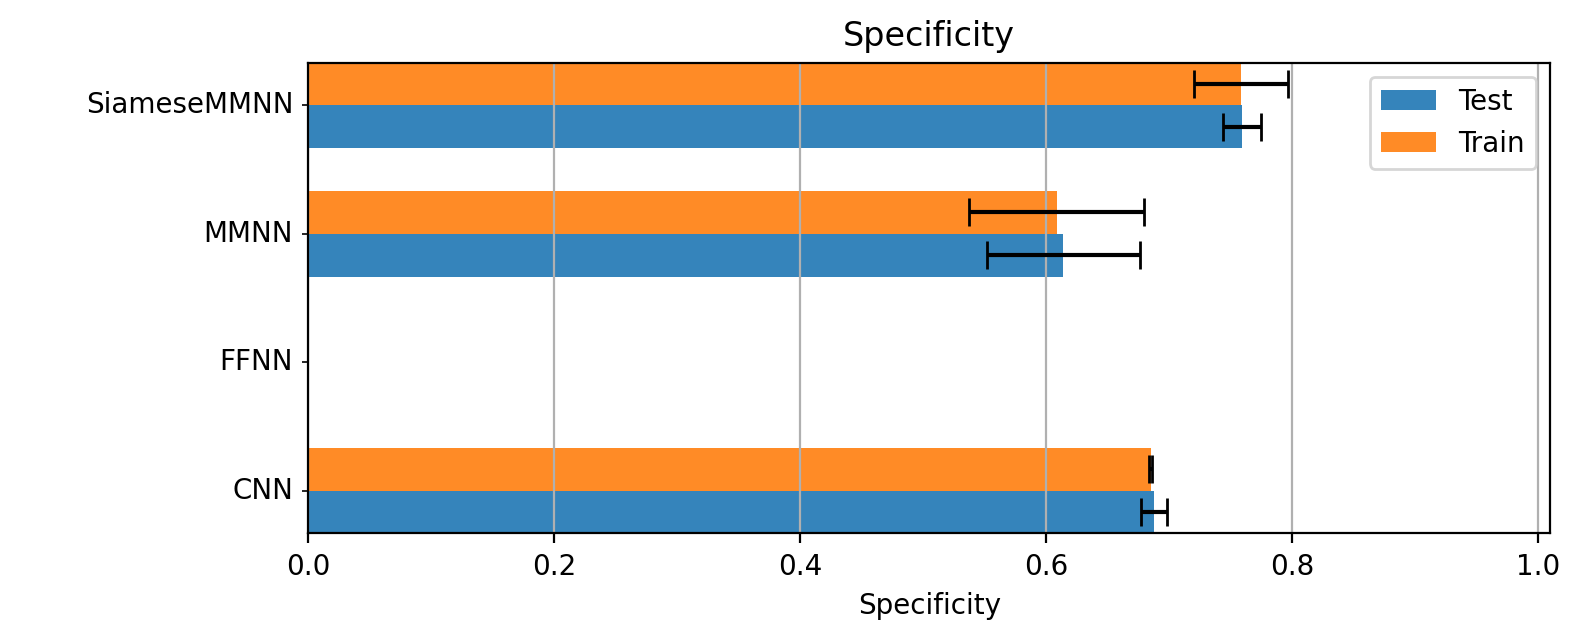

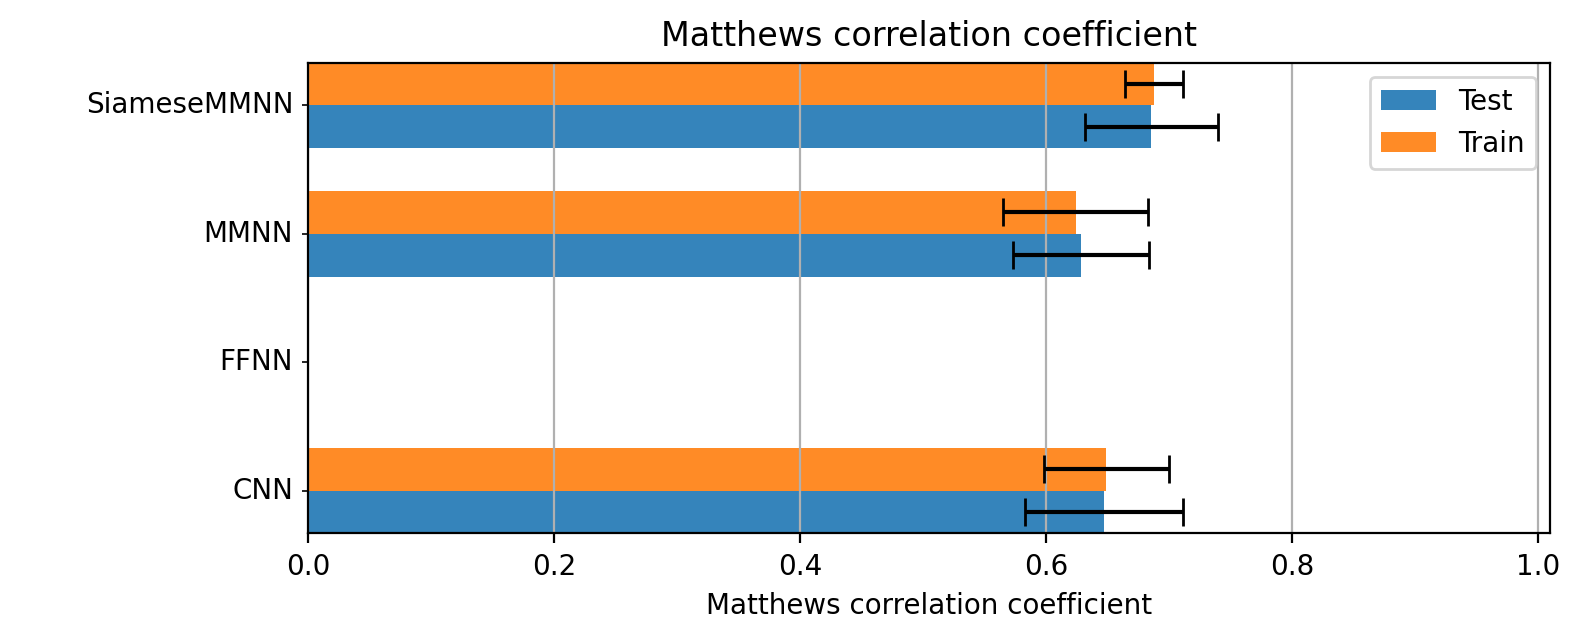

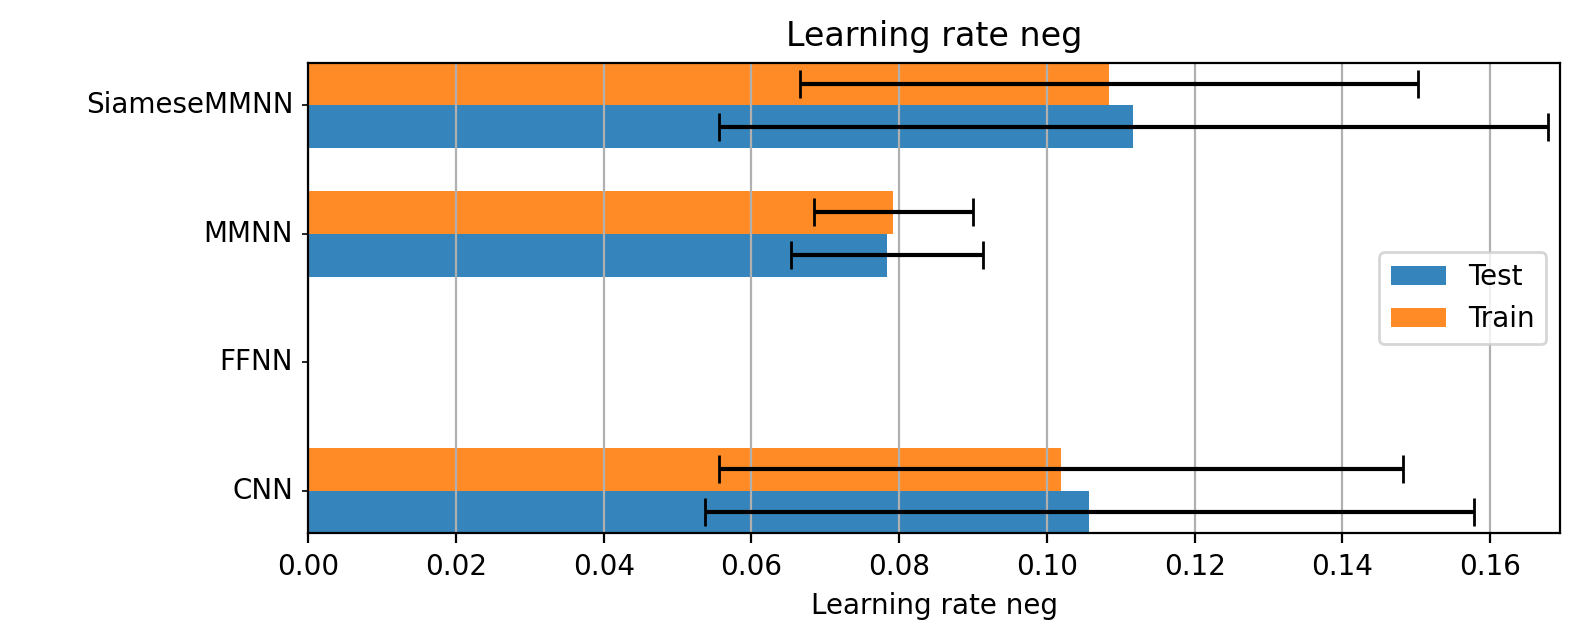

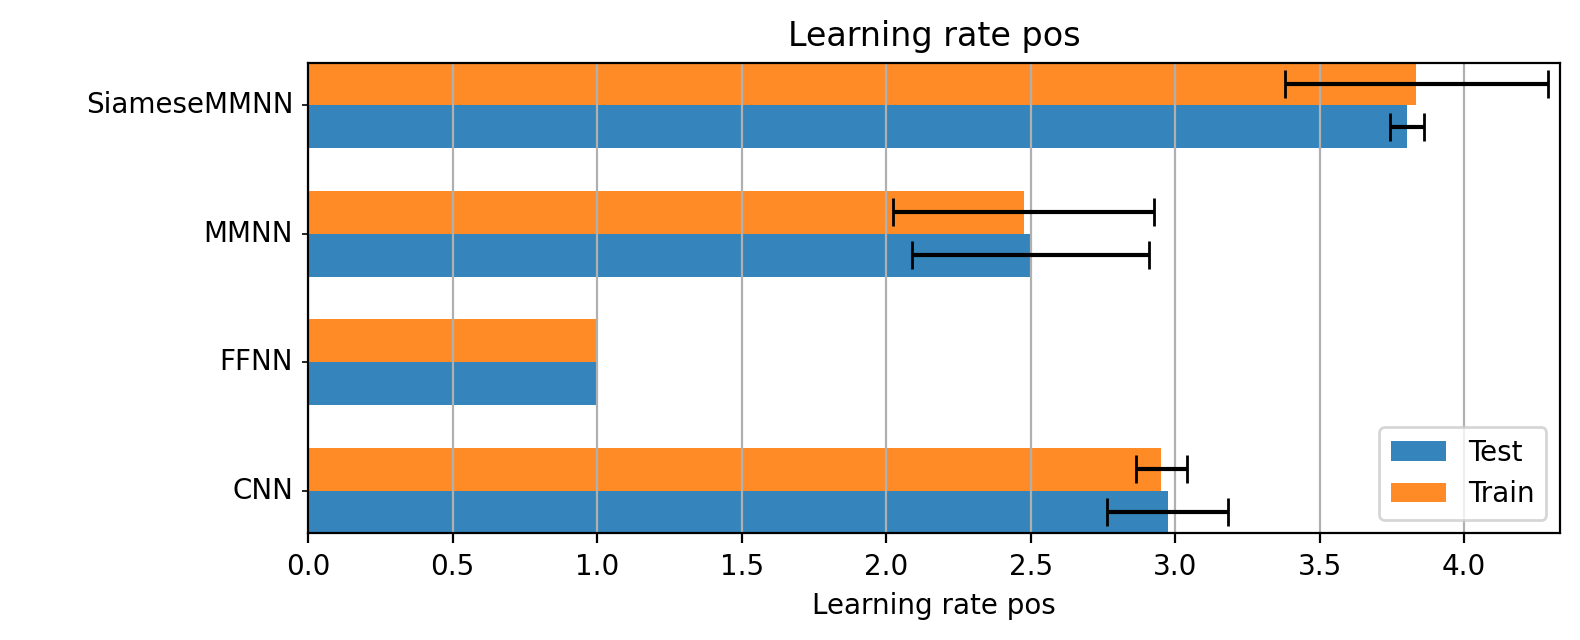

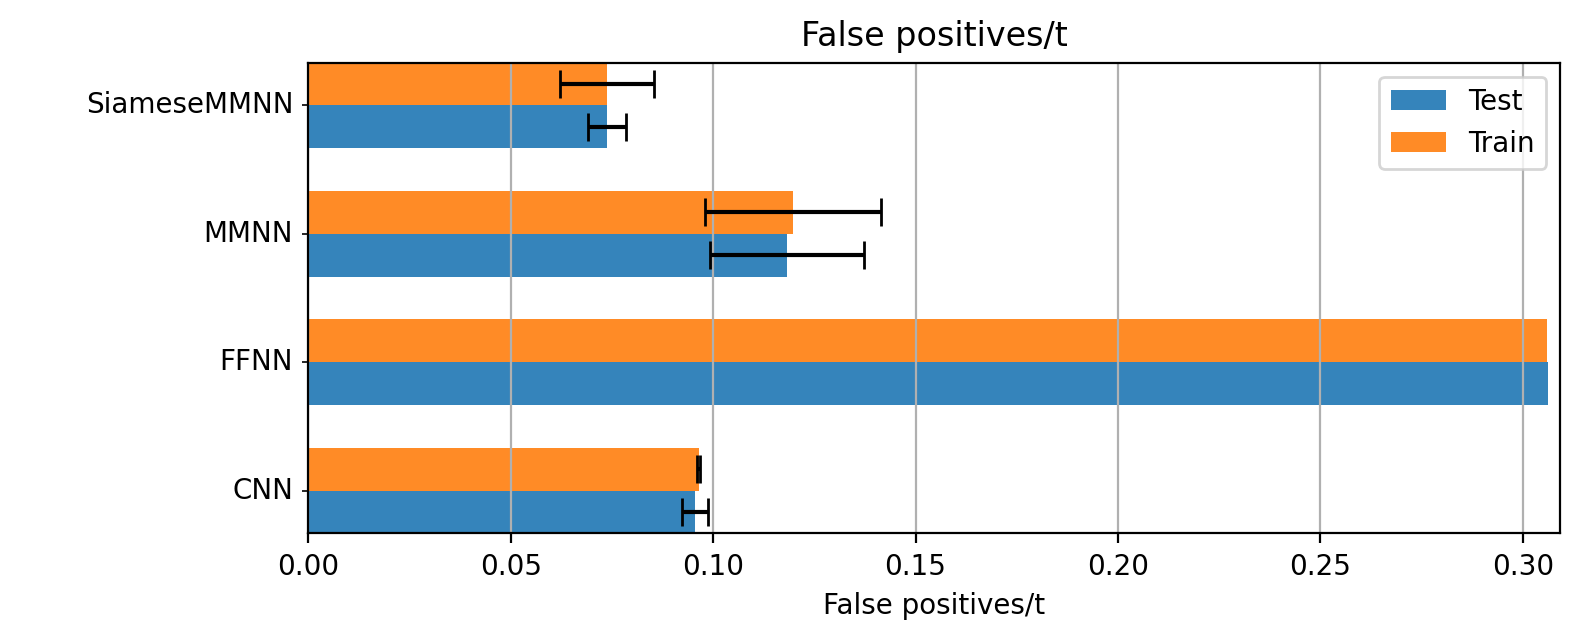

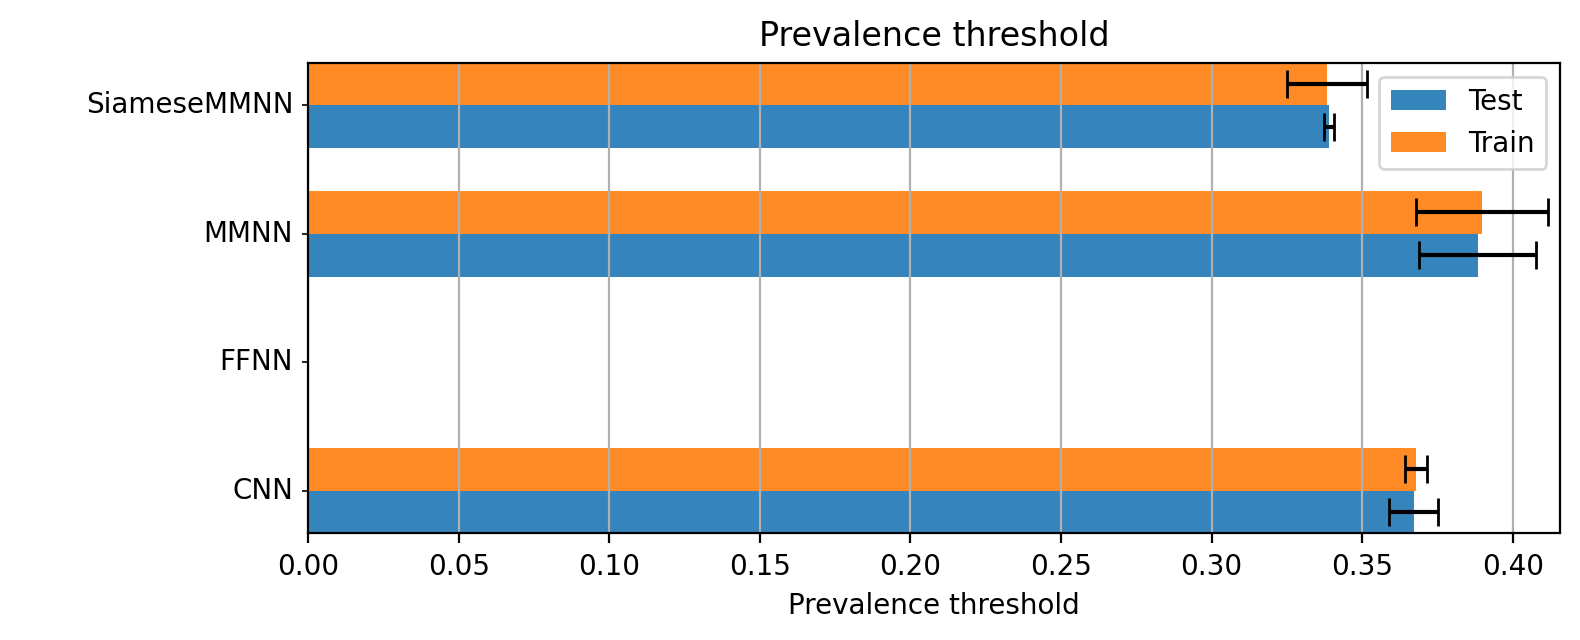

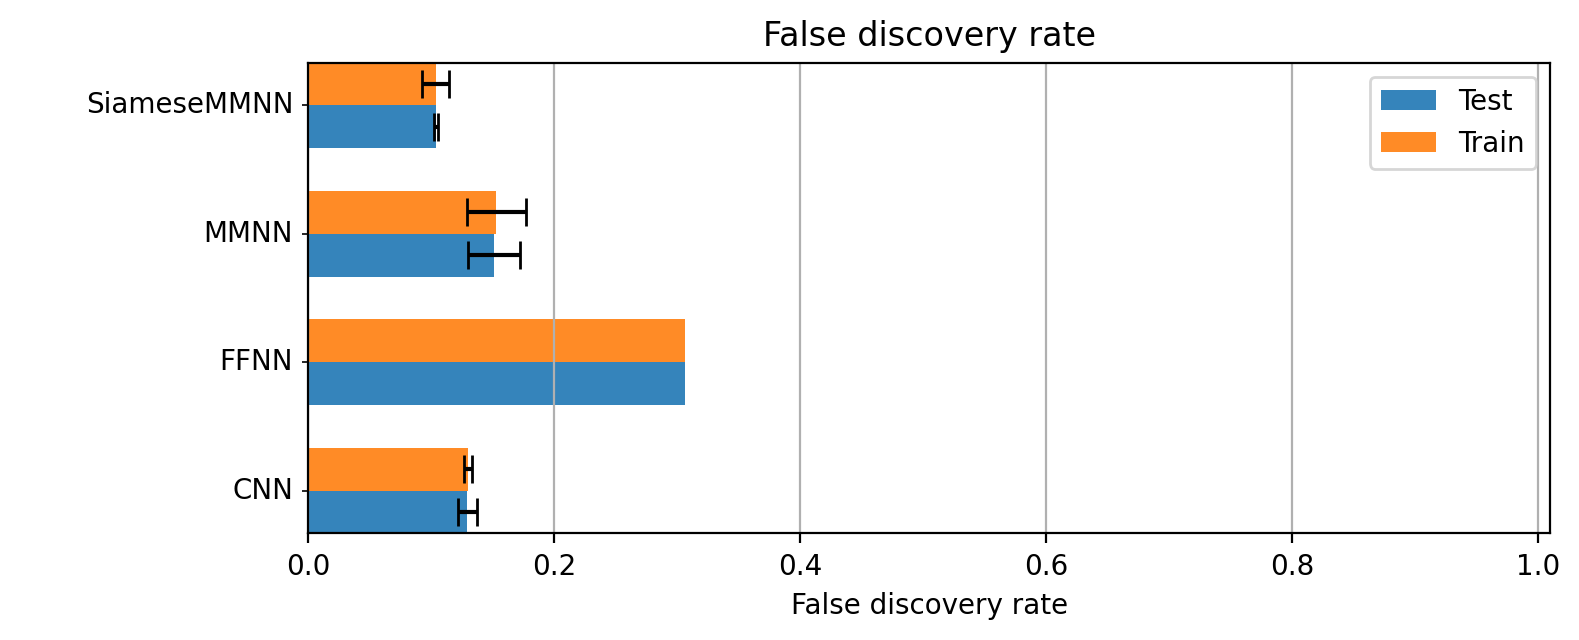

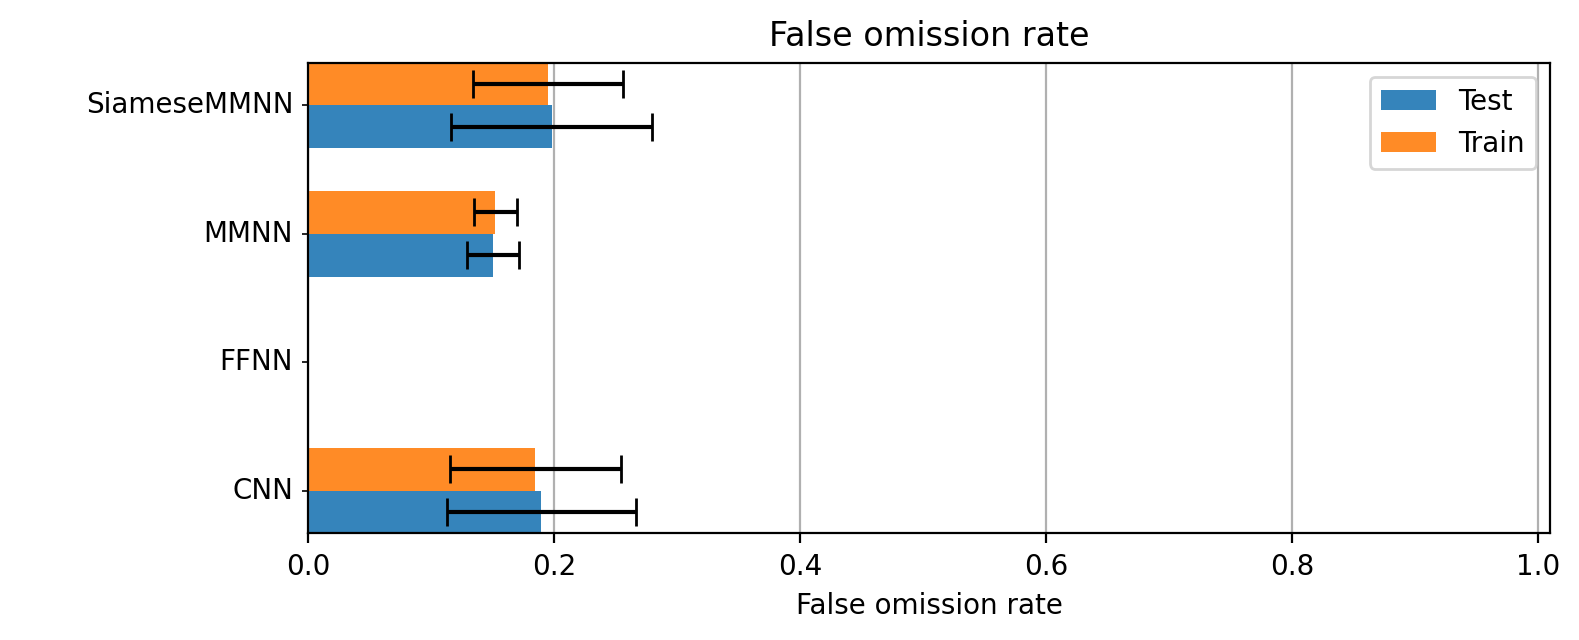

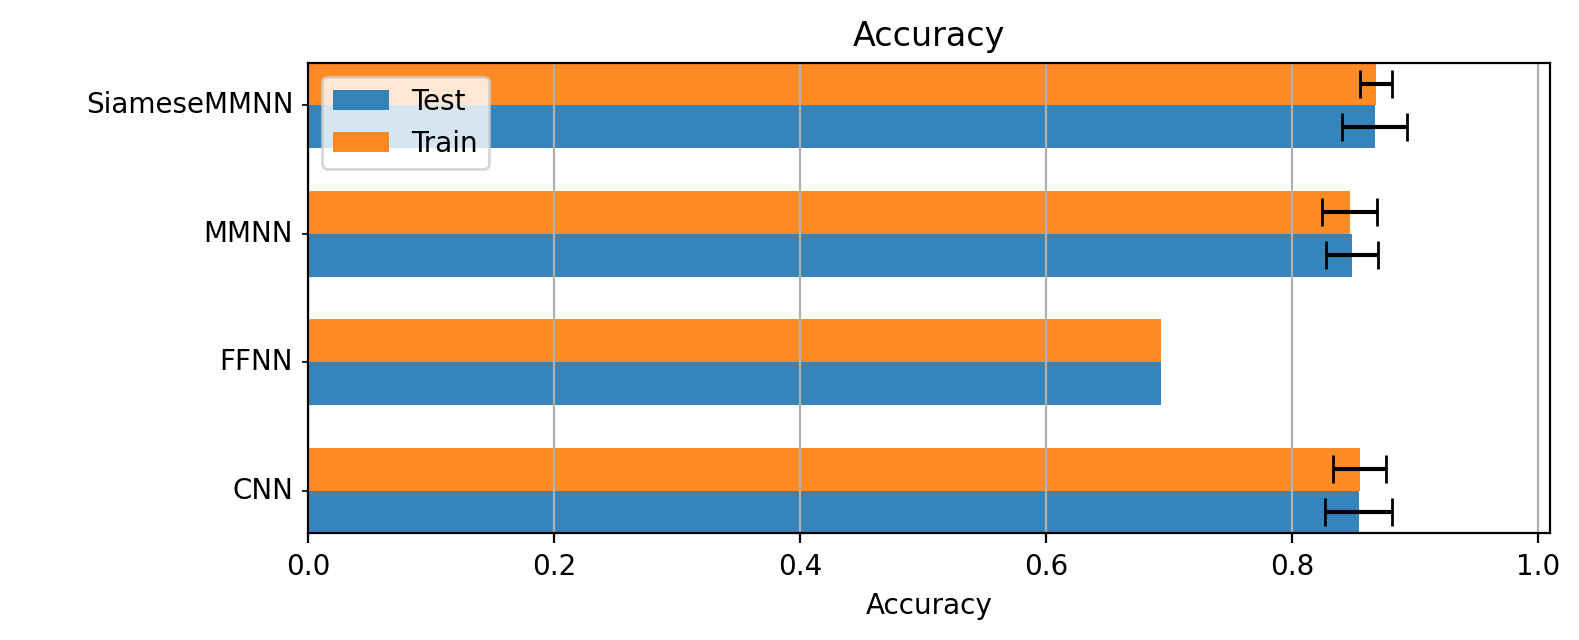

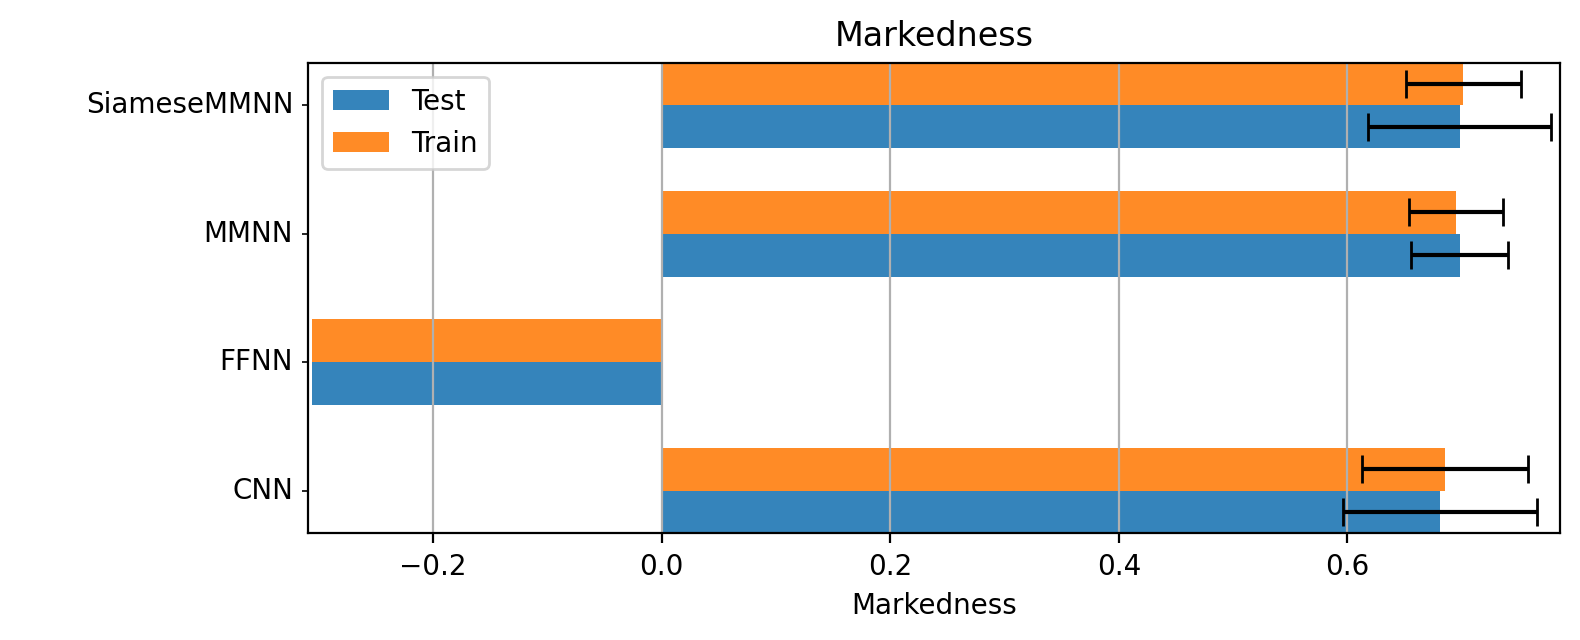

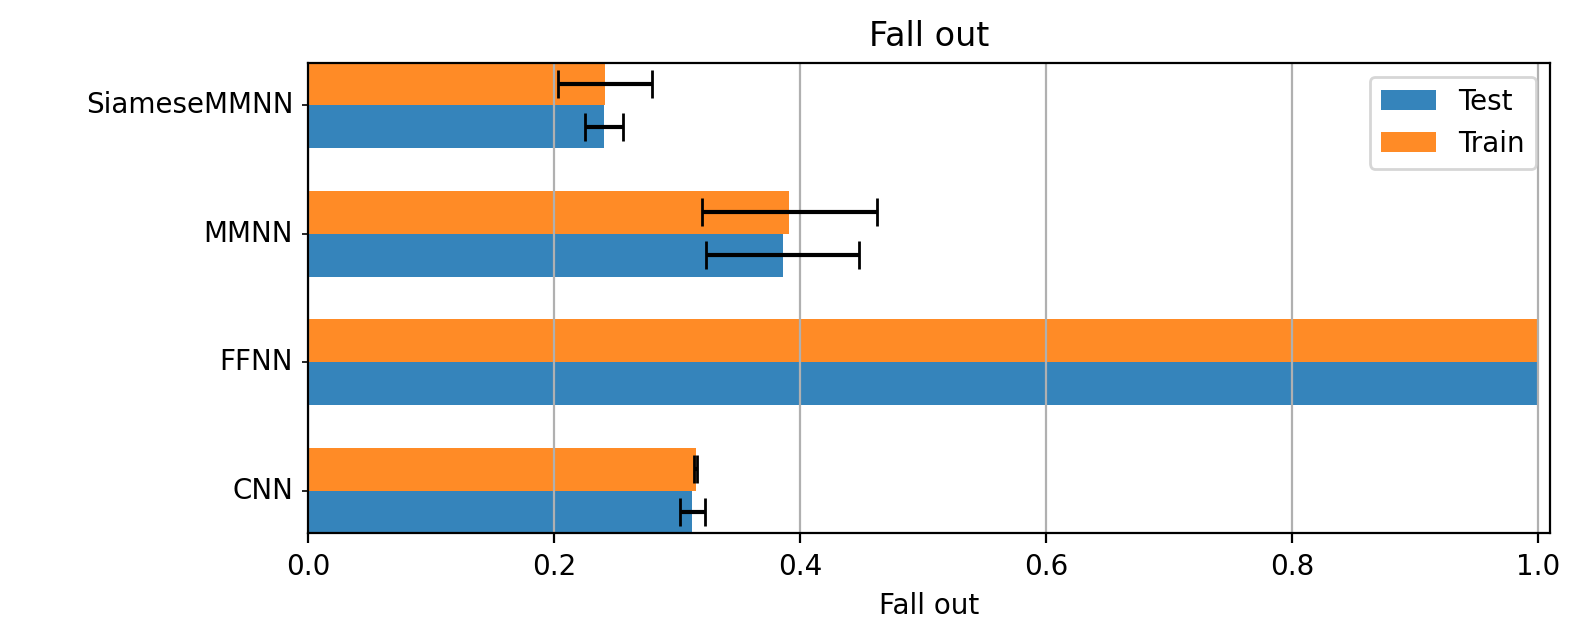

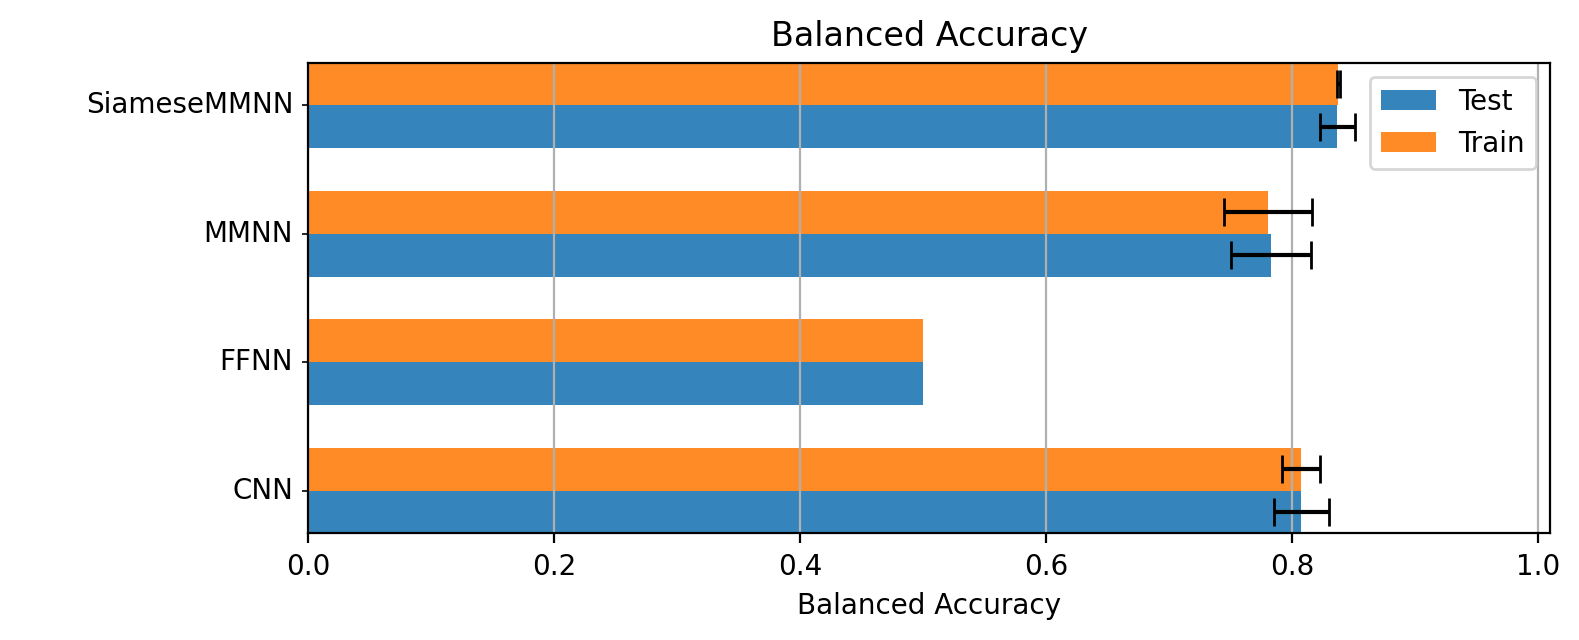

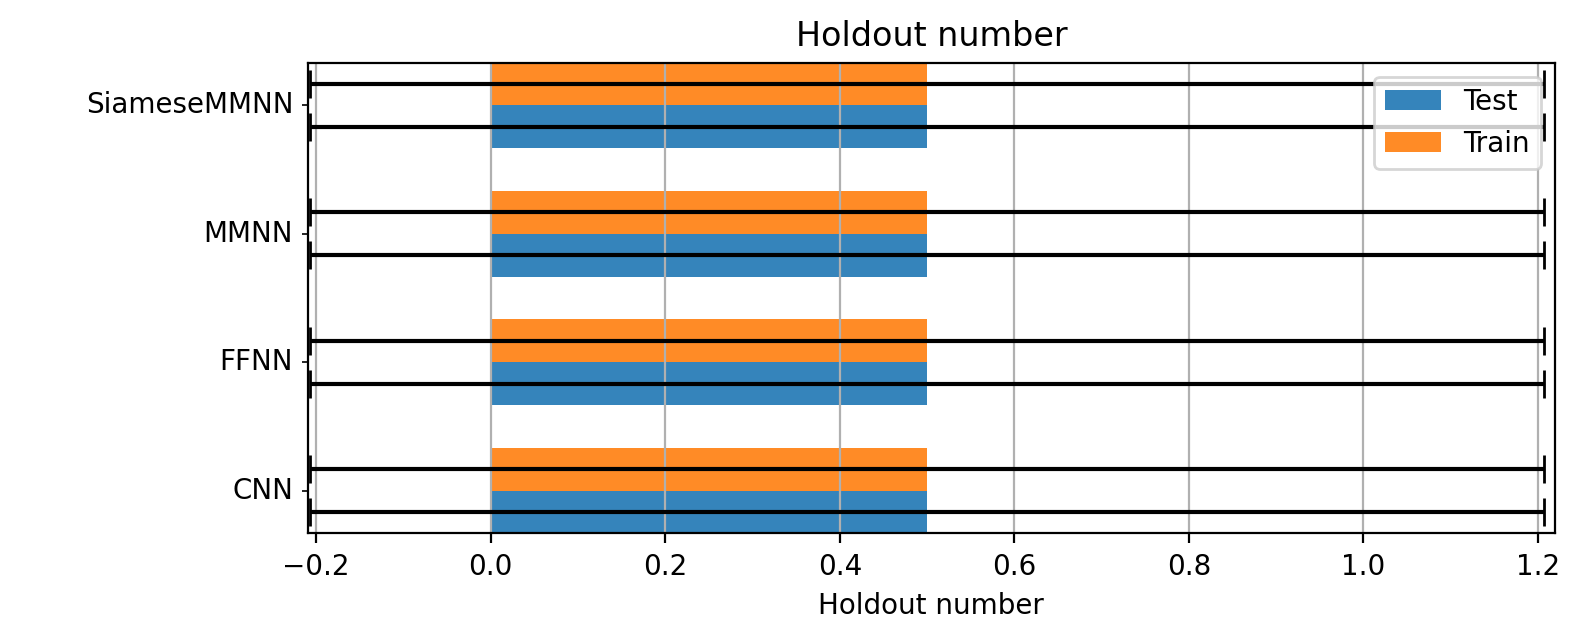

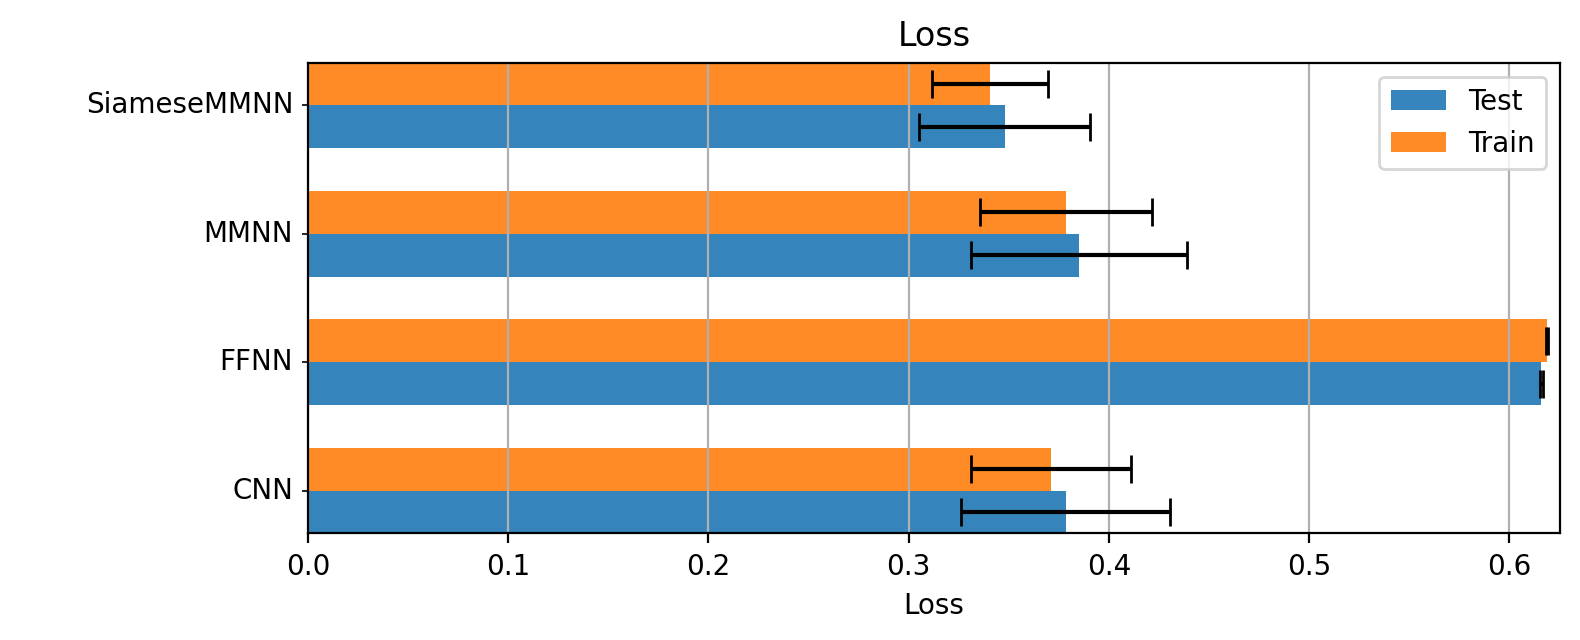

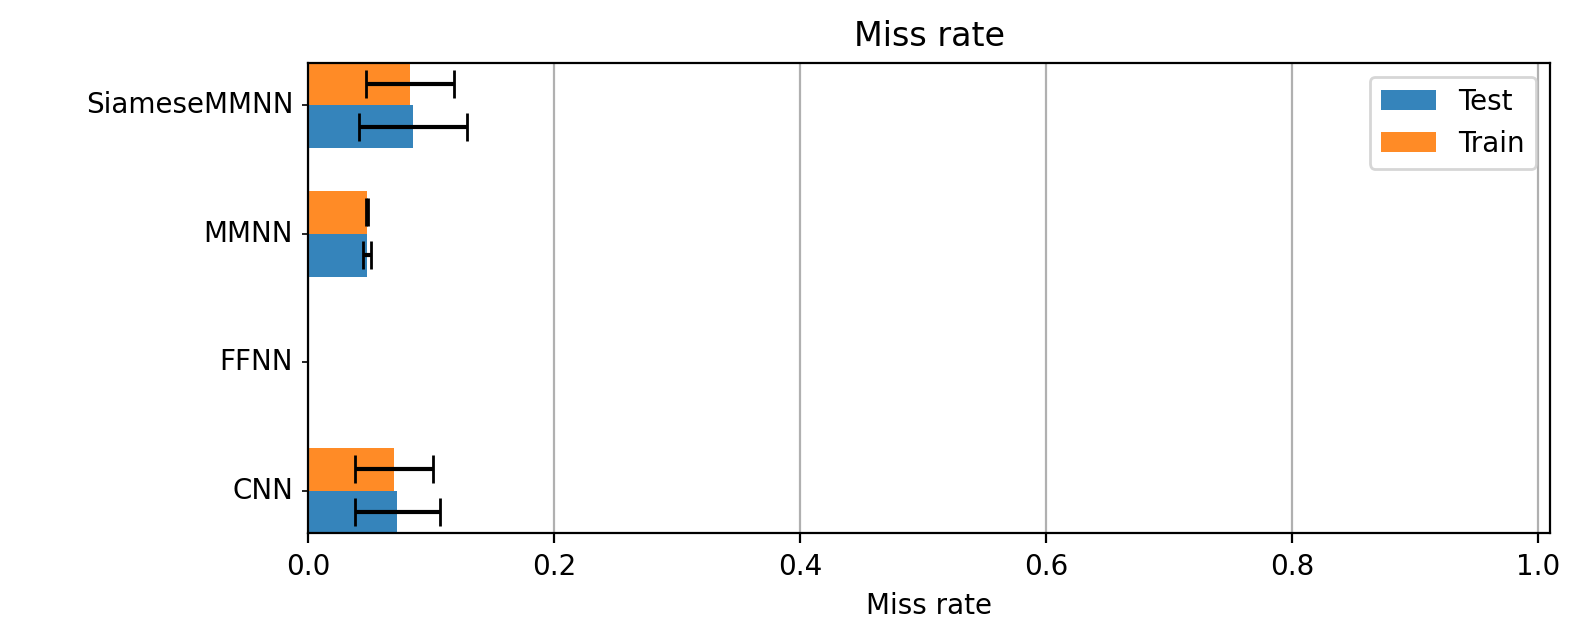

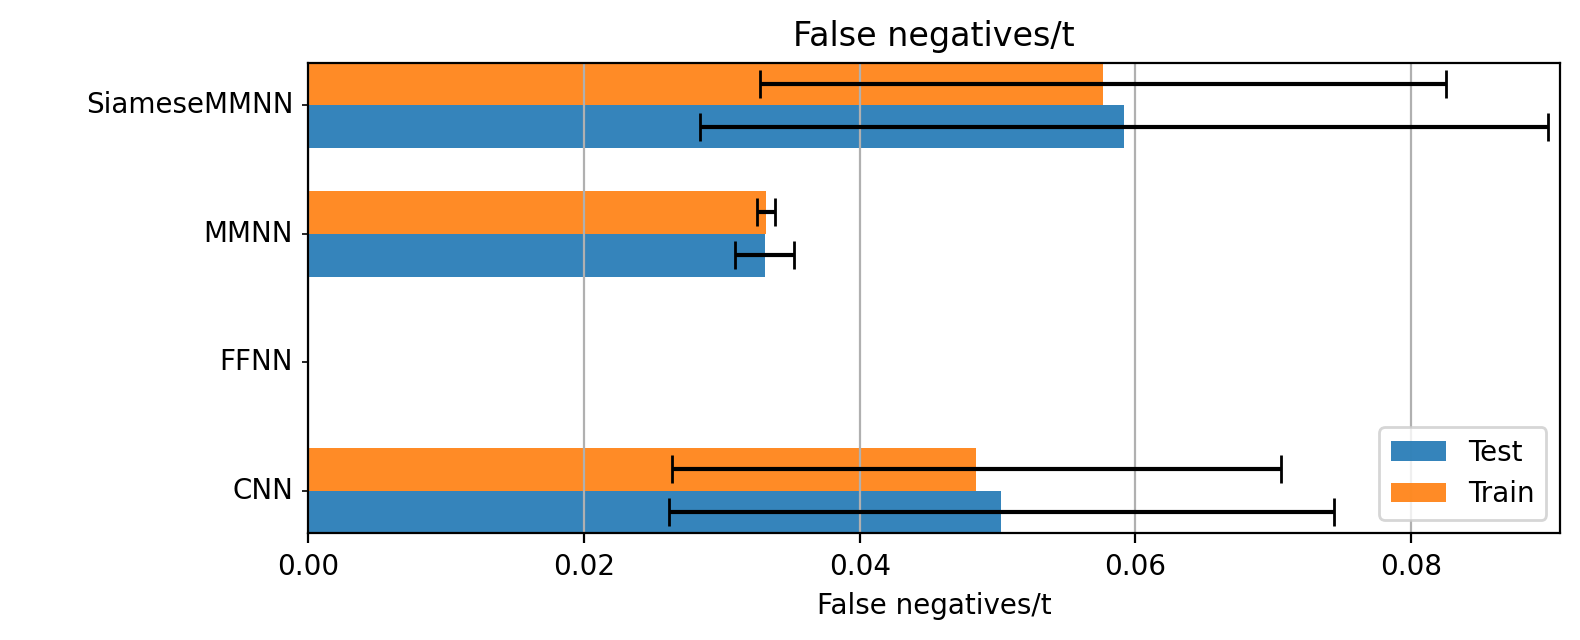

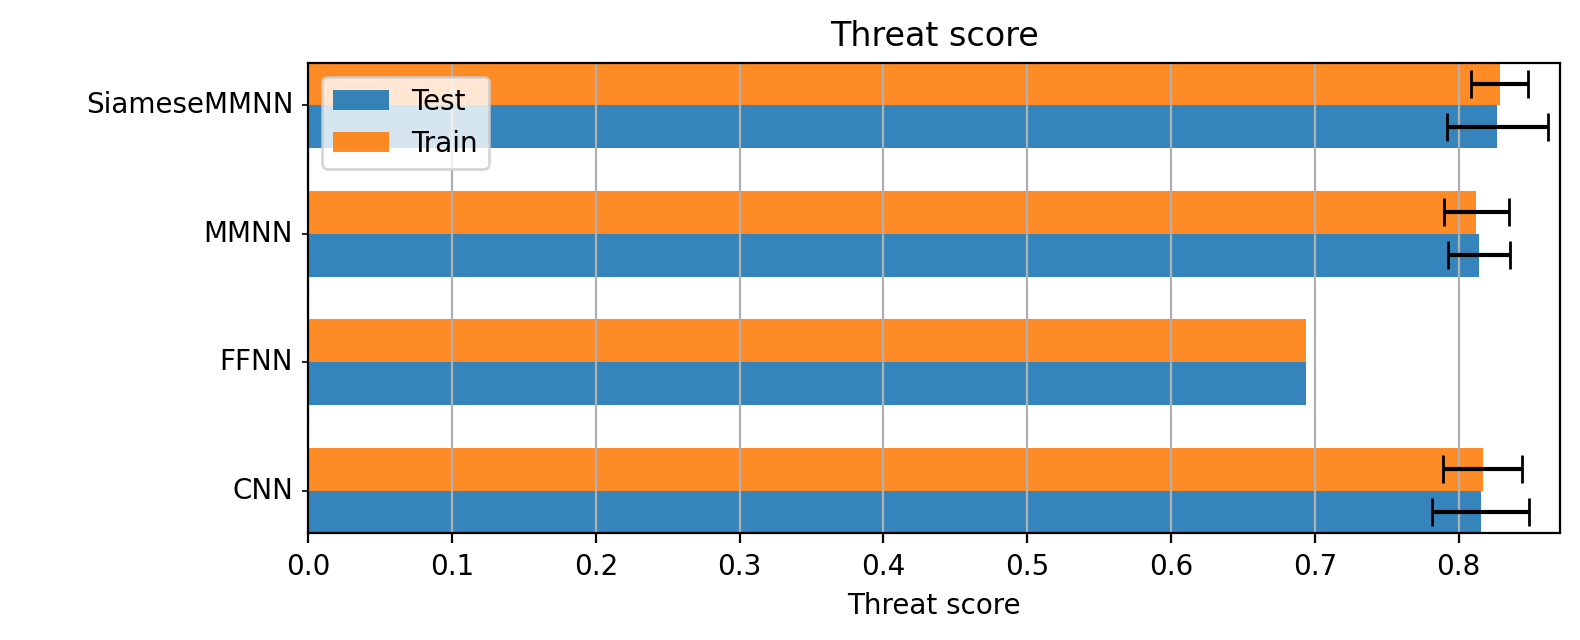

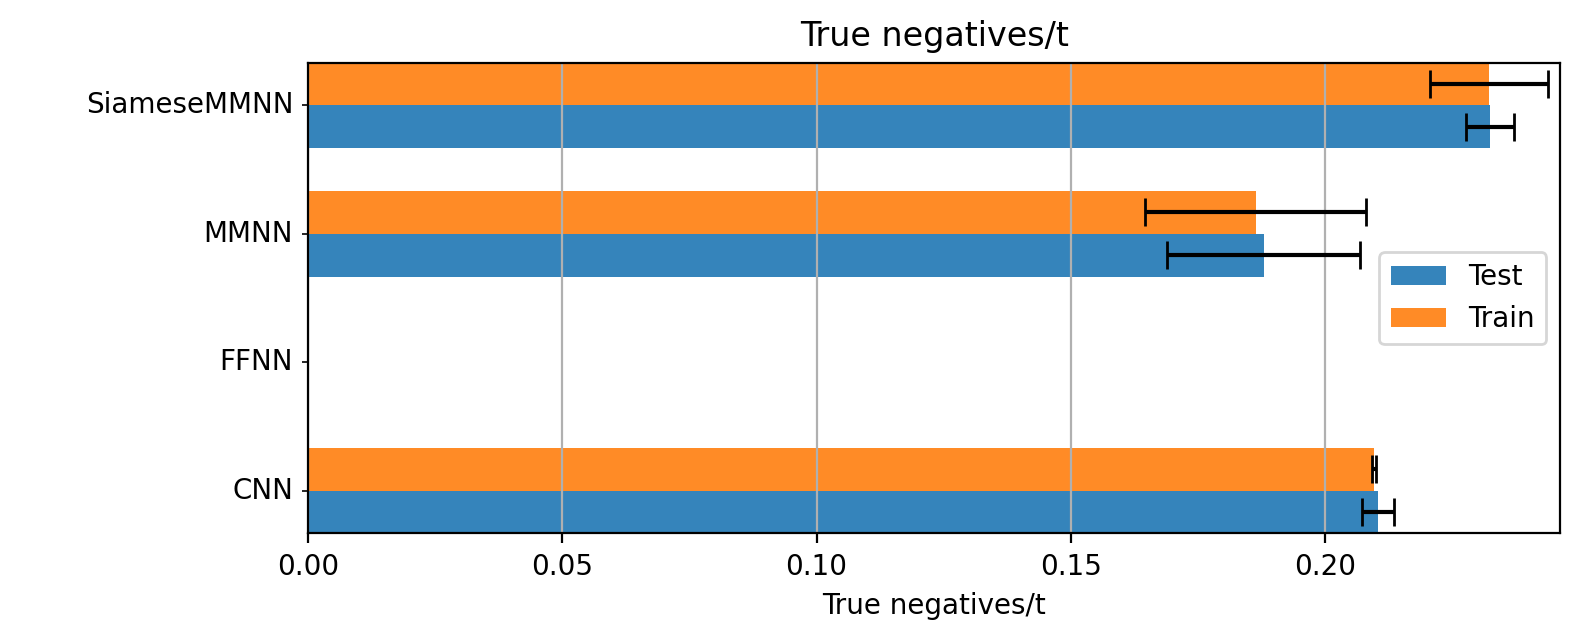

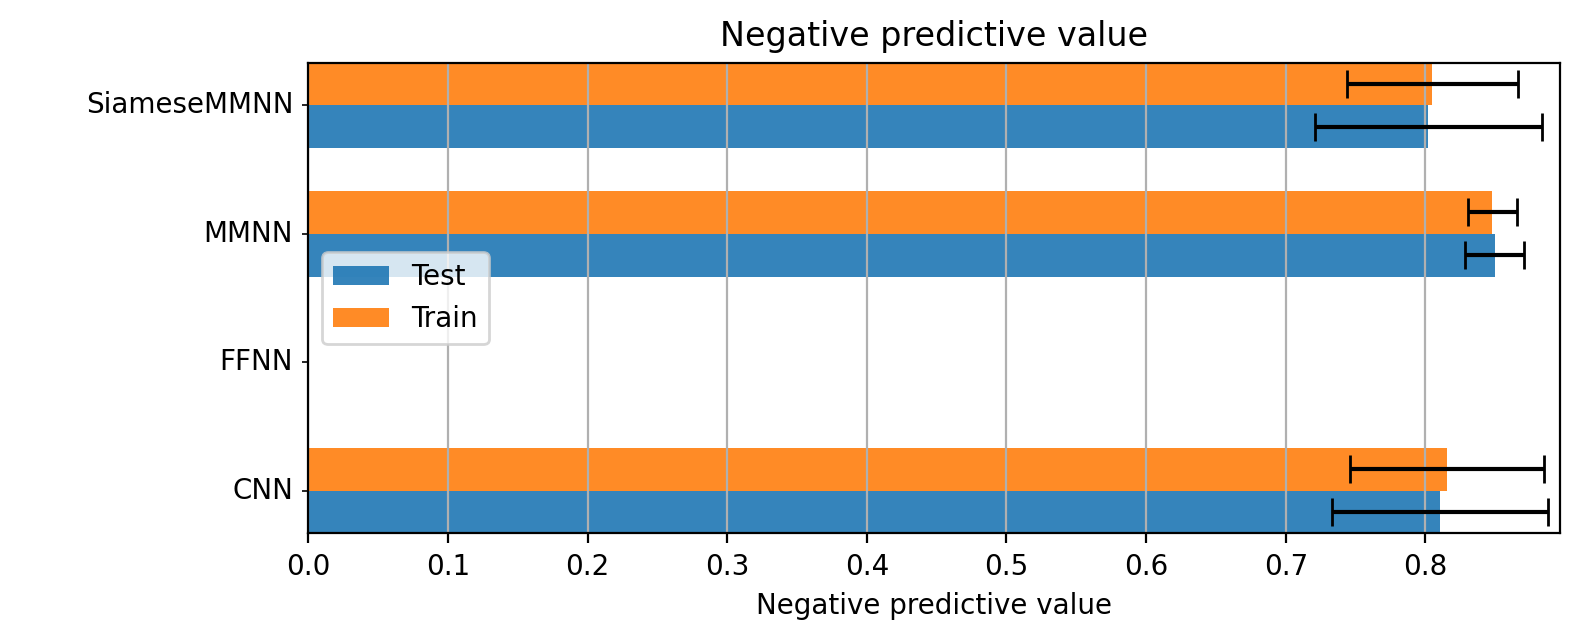

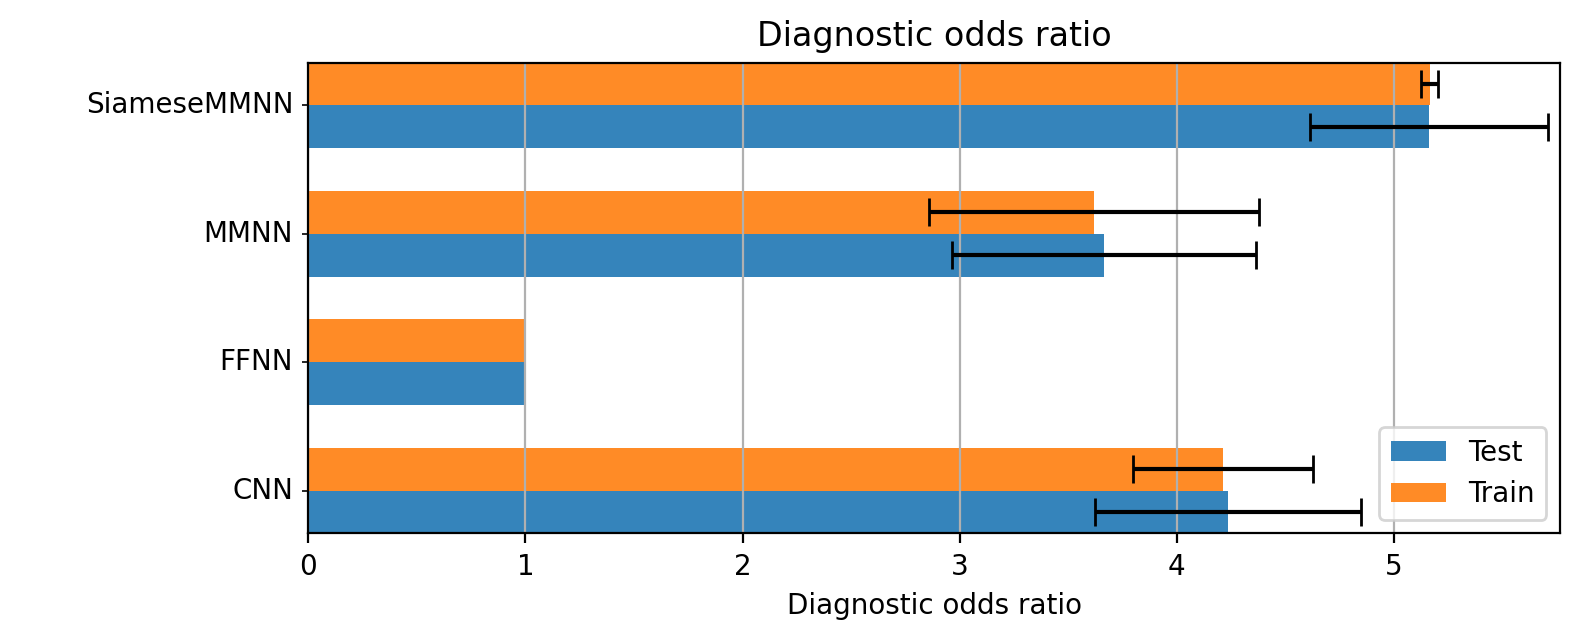

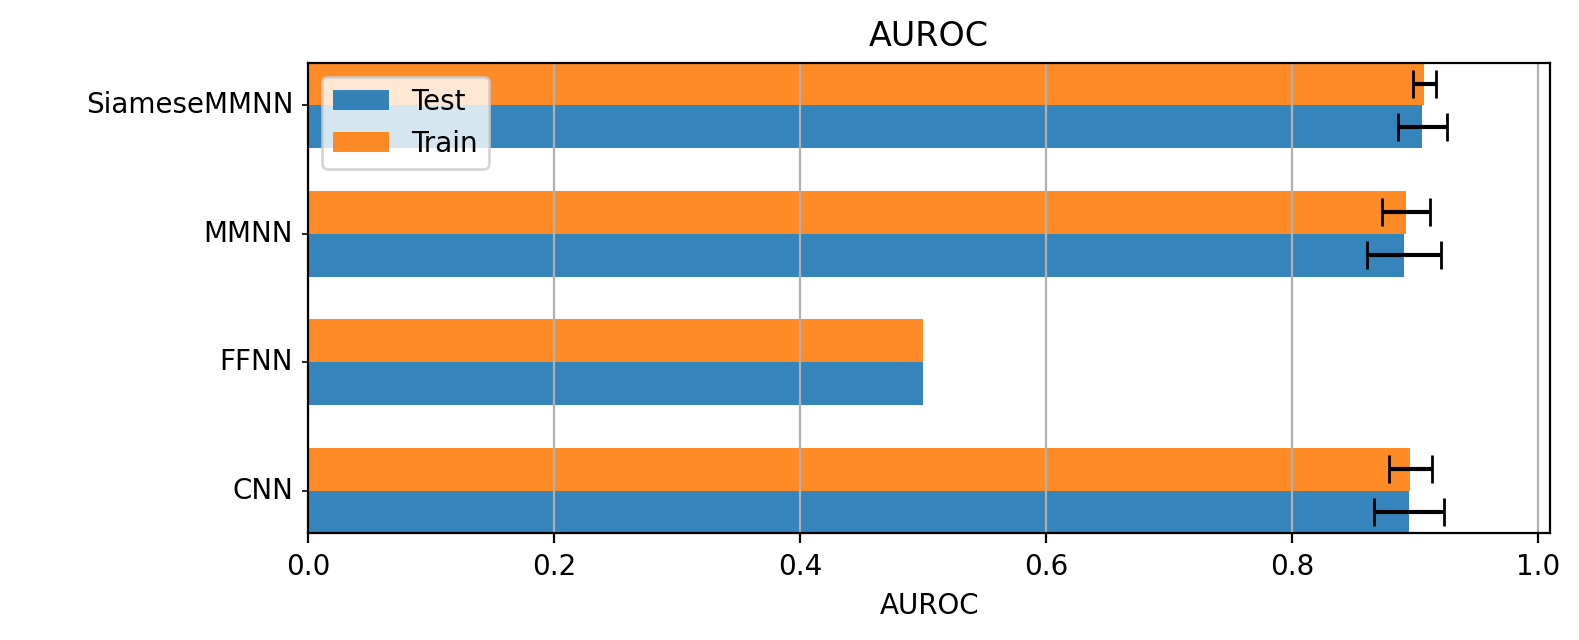

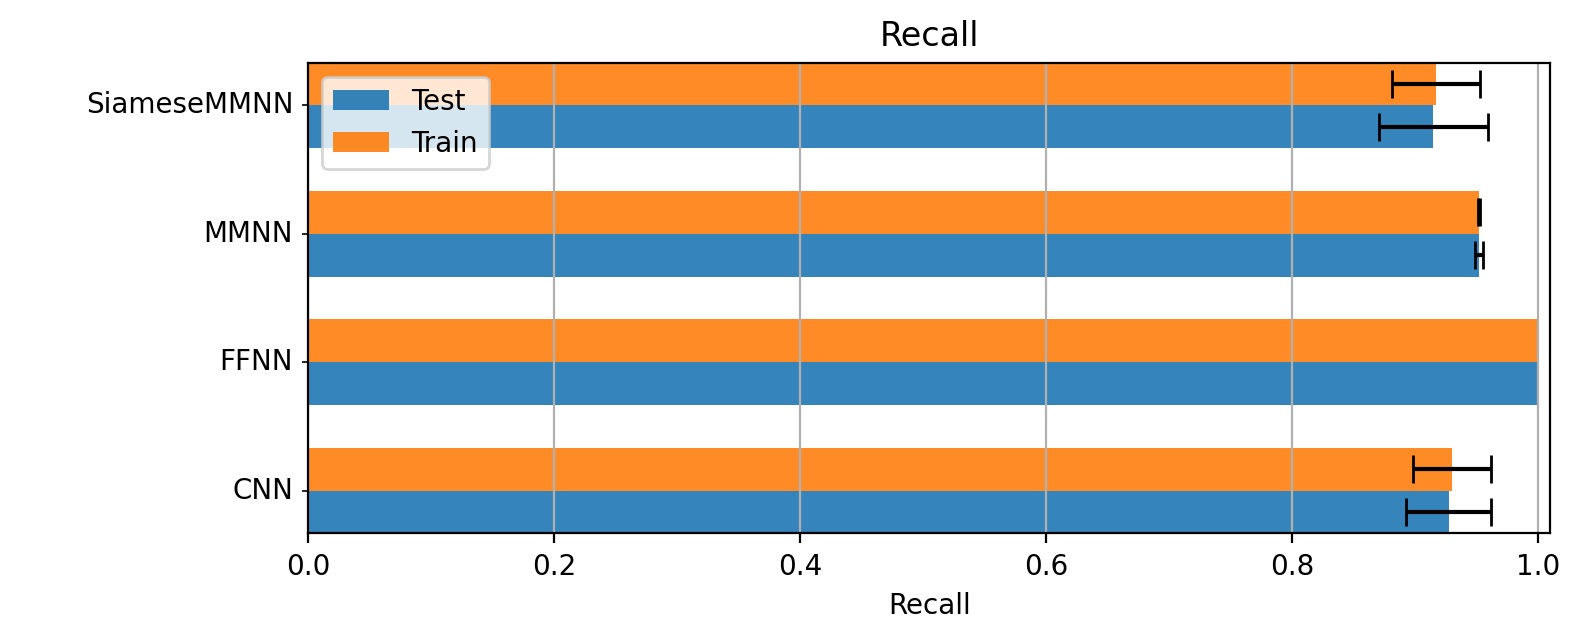

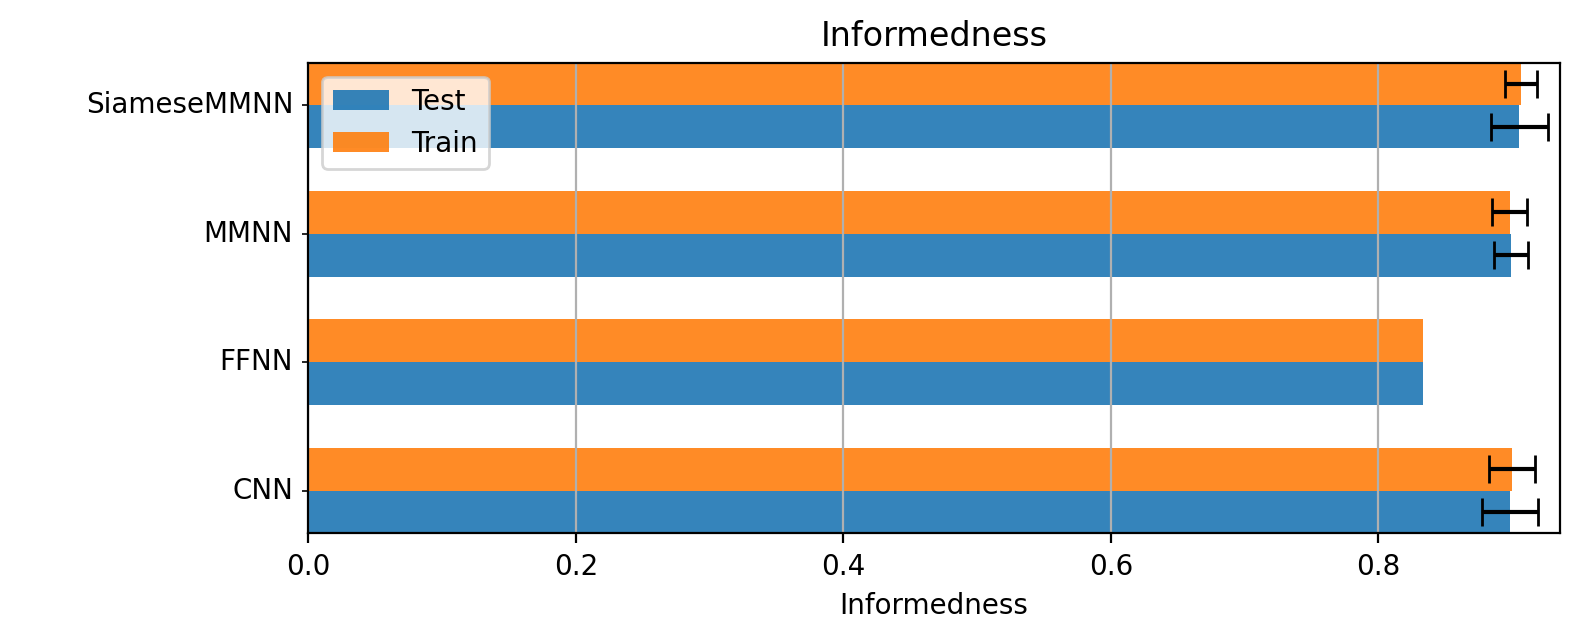

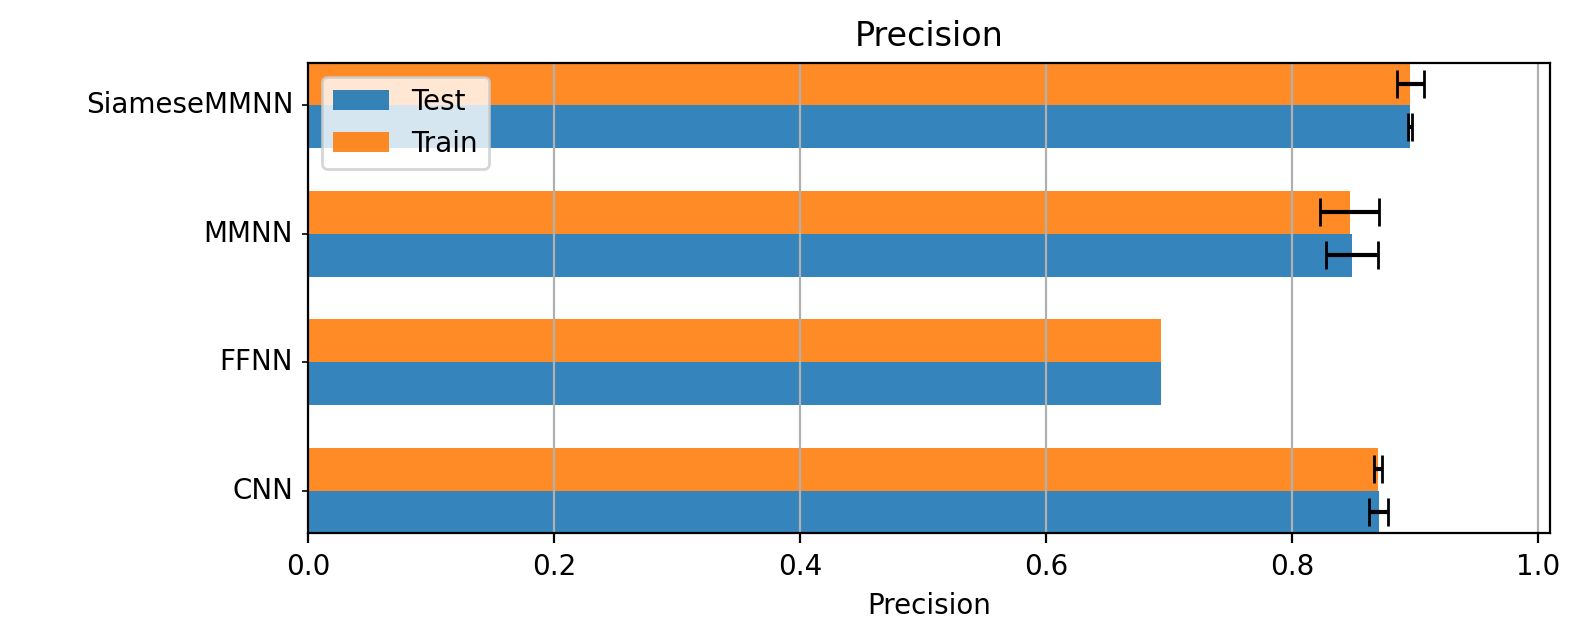

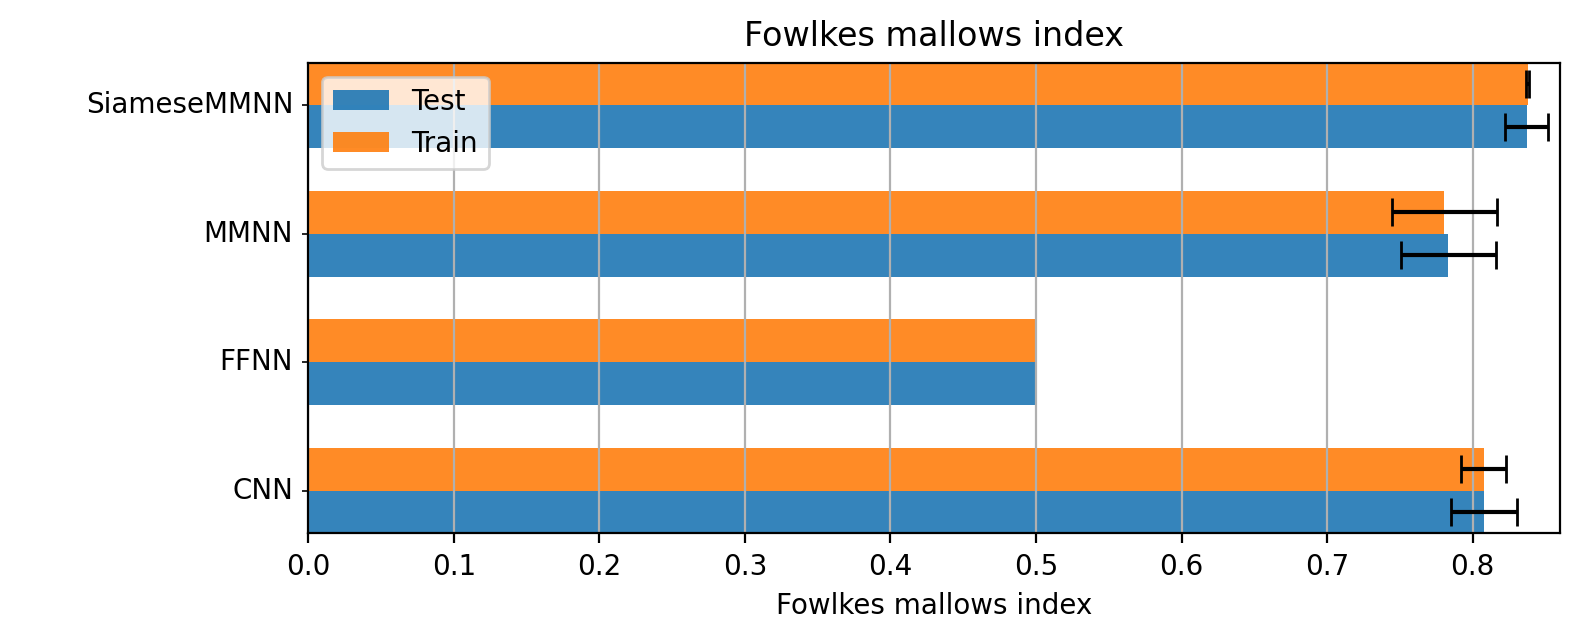

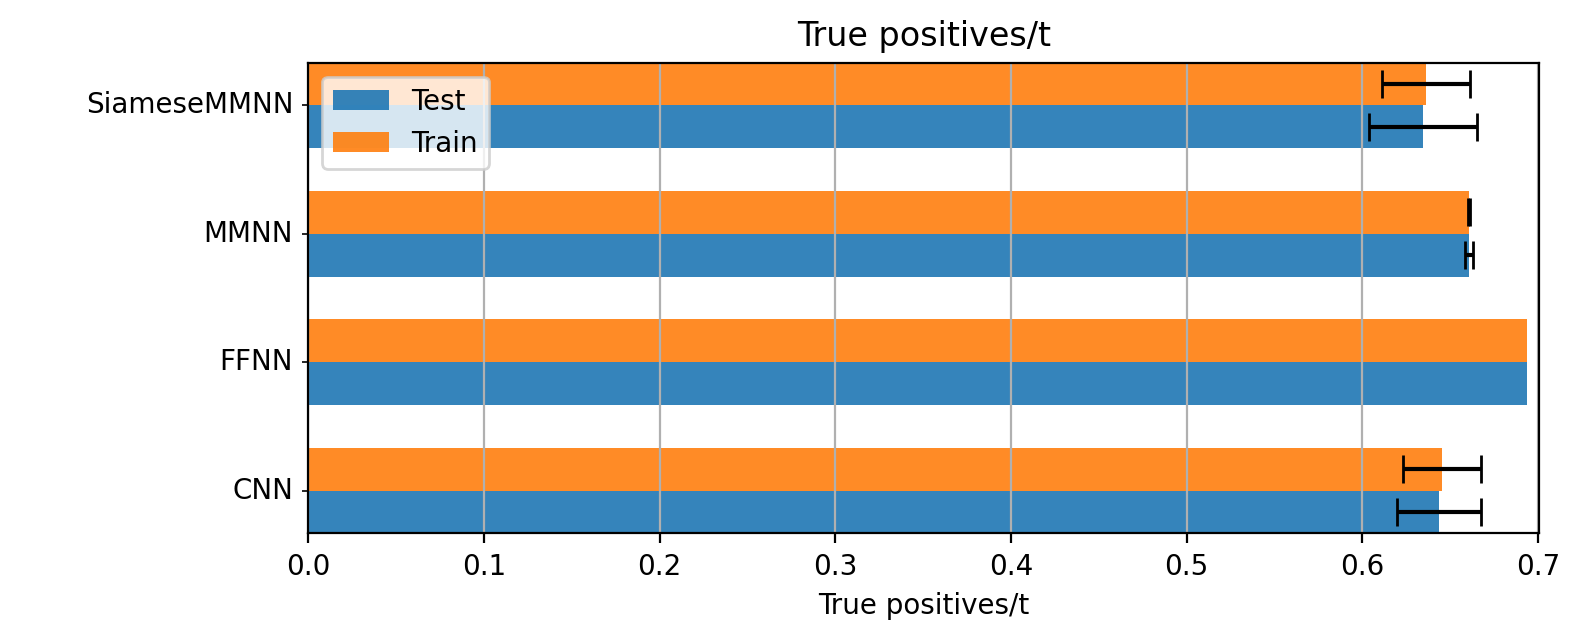

In [13]:
barplots(
    all_performance,
    groupby=["model_name", "run_type"],
    orientation="horizontal",
    height=8
)

In [14]:
from scipy.stats import wilcoxon

In [15]:
for model in all_performance.model_name.unique():
    model_performance = all_performance[(all_performance.model_name == model) & (all_performance.run_type == "test")]
    performance_with_feature_selection = model_performance[
        all_performance.use_feature_selection == "Feature Selection"
    ]
    performance_without_feature_selection = model_performance[
        all_performance.use_feature_selection == "No Feature Selection"
    ]

    for metric in ("AUPRC", "AUROC", "Accuracy"):
        print(
            model,
            metric,
            wilcoxon(performance_with_feature_selection[metric], performance_without_feature_selection[metric])
        )

AttributeError: 'DataFrame' object has no attribute 'use_feature_selection'

In [ ]:
for outer_model in all_performance.model_name.unique():
    outer_model_performance = all_performance[
        (all_performance.model_name == outer_model) &
        (all_performance.run_type == "test") & 
        (all_performance.use_feature_selection == "Feature Selection")
    ]
    for model in all_performance.model_name.unique():
        if outer_model >= model:
            continue
        model_performance = all_performance[
            (all_performance.model_name == model) &
            (all_performance.run_type == "test") & 
            (all_performance.use_feature_selection == "Feature Selection")
        ]

        for metric in ("AUPRC", "AUROC", "Accuracy"):
            outer, inner = outer_model_performance[metric], model_performance[metric]
            _, p_value = wilcoxon(outer, inner)
            if p_value < 0.01:
                if outer.mean() > inner.mean():
                    best_model, worse_model = outer_model, model
                else:
                    best_model, worse_model = model, outer_model
                print("The model {} outperforms the model {} with p-value {} on metric {}.".format(
                    best_model,
                    worse_model,
                    p_value,
                    metric
                ))
            else:
                print("The model {} is statistially indistinguishiable {} with p-value {} on metric {}.".format(
                    outer_model,
                    model,
                    p_value,
                    metric
                ))